<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/fully_dense_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# dataset build

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-05 12:09:37--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-05 12:09:37--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [          <=>       ]  33.20M  16.5MB/s    in 2.0s    

2021-03-05 12:09:40 (16.5 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]



In [3]:
!tar -xf MNIST.tar.gz


In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [5]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [6]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

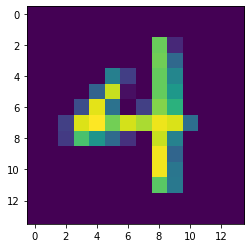

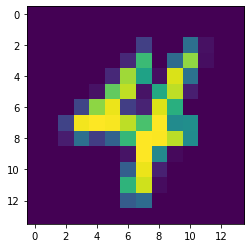

train shape : torch.Size([1000, 2, 14, 14])


In [7]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [8]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


In [9]:
for el in train_dataloader:
  # image , target, classes
  print(el[0].shape, el[1].shape, el[2].shape)
  break

torch.Size([100, 2, 14, 14]) torch.Size([100]) torch.Size([100, 2])


# FullyDenseNN

In [10]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

# Train tools

In [11]:
def train_epoch(network_ , optimizer_ , criterion = F.binary_cross_entropy ):
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data).flatten()
    loss = criterion(output, target.to(torch.float32))
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( (target == torch.round(output) ).sum().item() )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [12]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += criterion_(output.flatten(), target.to(torch.float32)).item()
      acc += (target == torch.round(output.flatten()) ).sum().item()

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [13]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, train_loss , train_acc , test_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

# stats

In [14]:
def train_multiple_runs( network_class , runs = 10 , epoch = 30):
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = [],[],[],[]
  
  for i in range(runs):
    n = network_class()
    optimizer = optim.SGD(n.parameters(), lr=0.01, momentum=0.5)
    criterion = F.binary_cross_entropy

    tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(n , optimizer , criterion , epoch , debug_ = False)
    all_train_loss.append(tot_train_loss)
    all_train_acc.append(tot_train_acc)
    all_test_loss.append(tot_test_loss)
    all_test_acc.append(tot_test_acc)

  return all_train_loss , all_train_acc , all_test_loss , all_test_acc

In [15]:
def plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc ):
  epochs = range(1, len(tot_train_loss)+1 )
  plt.plot(epochs, tot_train_loss, 'g', label='Training loss')
  plt.plot(epochs, tot_test_loss, 'b', label='Test loss')
  plt.plot(epochs, tot_train_acc, 'r', label='Training acc')
  plt.plot(epochs, tot_test_acc, 'y', label='Test acc')
  plt.title('Training and Test loss/acc')
  plt.xlabel('Epochs')
  plt.ylabel('loss/acc')
  plt.ylim((0,1))
  plt.legend()
  plt.show()

In [16]:
import numpy as np
def plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc):
  trl_mean = np.array(all_train_loss).mean(axis = 0)
  tel_mean = np.array(all_train_acc).mean(axis = 0)
  tra_mean = np.array(all_test_loss).mean(axis = 0)
  tea_mean = np.array(all_test_acc).mean(axis = 0)

  trl_std = np.array(all_train_loss).std(axis = 0)
  tel_std = np.array(all_train_acc).std(axis = 0)
  tra_std = np.array(all_test_loss).std(axis = 0)
  tea_std = np.array(all_test_acc).std(axis = 0)

  epochs = range(1, len(tea_std)+1 )

  temp = [ [trl_mean , trl_std] , [tel_mean , tel_std] , [tra_mean , tra_std] , [tea_mean , tea_std] ]

  for g in temp : 
    plt.plot( epochs , g[0] )
    plt.fill_between(epochs, g[0]-g[1], g[0]+g[1] ,alpha=0.3)

  plt.ylim((-0.1,1.1))


In [17]:
all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( FullyDenseNet , runs = 10 , epoch = 30)

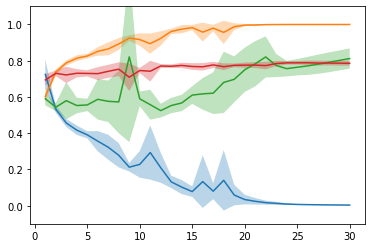

In [18]:
plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc)